Eduardo Vasquez-Villalpando
Updated dataset can always be acquired via https://cacertappliances.energy.ca.gov/Pages/ApplianceSearch.aspx

In [1]:
import pandas as pd
import numpy as np
import imblearn
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import StackingRegressor
# pd.set_option("display.max_columns", None)
# pd.set_option("display.max_rows", None)

# Importing full data, dropping duplicates

In [108]:
df = pd.read_csv('full_data.csv')
df = df[df['Computer Type'] == 'High Expandability Computer']
df = df[[
    'Number of CPU Cores', 'Core Speed (gigahertz)', \
    'Expandability Score', \
    'Number of 3.5" hard-disk drives and Others (other than main storage)', \
    'Number of solid-state drives (other than main storage)', \
    'First Discrete GPU Frame Buffer Bandwidth (rounded to nearest gigabyte per second)', \
    'Total Number of System Memory Channels Used', \
    'First channel system memory (gigabytes)', \
    'First channel system memory bandwidth (gigabytes/second)', \
    'Motherboard model number', \
    'Power supply model number', \
    'Internal power supply size (watts)', \
    'Short-idle power (watts)',
'Total Annual Energy Consumption (kilowatt hours per year)']]
df['Motherboard model number'] = df['Motherboard model number'].str.upper()
df['Power supply model number'] = df['Power supply model number'].str.upper()
df.drop_duplicates(inplace = True)

In [7]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1862 entries, 0 to 8171
Data columns (total 13 columns):
 #   Column                                                                              Non-Null Count  Dtype  
---  ------                                                                              --------------  -----  
 0   Number of CPU Cores                                                                 1862 non-null   float64
 1   Core Speed (gigahertz)                                                              1862 non-null   float64
 2   Expandability Score                                                                 1862 non-null   float64
 3   Number of 3.5" hard-disk drives and Others (other than main storage)                1862 non-null   float64
 4   Number of solid-state drives (other than main storage)                              1862 non-null   float64
 5   First Discrete GPU Frame Buffer Bandwidth (rounded to nearest gigabyte per second)  1862 non-null

In [8]:
df.describe()

,Number of CPU Cores,Core Speed (gigahertz),Expandability Score,"Number of 3.5"" hard-disk drives and Others (other than main storage)",Number of solid-state drives (other than main storage),First Discrete GPU Frame Buffer Bandwidth (rounded to nearest gigabyte per second),Total Number of System Memory Channels Used,First channel system memory (gigabytes),First channel system memory bandwidth (gigabytes/second),Internal power supply size (watts),Short-idle power (watts)
count,1862.000000,1862.000000,1862.000000,1862.000000,1862.000000,1862.000000,1862.000000,1862.000000,1862.000000,1862.000000,1862.000000
mean,11.524168,3.482057,740.080559,0.052095,0.869495,566.408324,2.023093,8.867884,29.971660,778.088077,54.936332
std,4.116937,0.187673,53.878273,0.229415,0.358580,161.042076,0.276237,3.881472,20.301389,131.121713,13.640193
min,4.000000,2.500000,385.000000,0.000000,0.000000,48.000000,1.000000,8.000000,16.000000,500.000000,32.200000
25%,8.000000,3.400000,710.000000,0.000000,1.000000,512.000000,2.000000,8.000000,28.800000,650.000000,45.442500
50%,10.000000,3.500000,745.000000,0.000000,1.000000,512.000000,2.000000,8.000000,28.800000,750.000000,52.745000
75%,16.000000,3.500000,760.000000,0.000000,1.000000,512.000000,2.000000,8.000000,28.800000,850.000000,62.260000
max,32.000000,5.200000,960.000000,2.000000,3.000000,936.200000,4.000000,64.000000,519.200000,1600.000000,175.000000


## Power Consumption Measurements

In [21]:
power = pd.read_csv('SearchResults.csv')
power = power[['Short-idle power (watts)', 'Long-idle power (watts)', 'Computer sleep mode power (watts)']]

<AxesSubplot:ylabel='Count'>

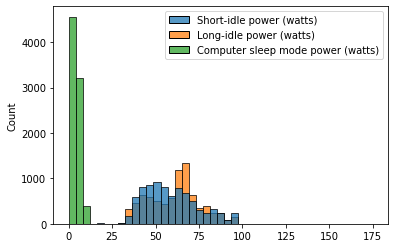

In [25]:
sns.histplot(data = power)

In [32]:
pd.DataFrame(power.describe()).iloc[[1, 2]]

,Short-idle power (watts),Long-idle power (watts),Computer sleep mode power (watts)
mean,58.958719,60.870154,4.266051
std,15.260163,14.972945,2.086310


## Expandability

In [111]:
# Binarizing Expandability Score
df['HES'] = df['Expandability Score'].apply(lambda x: True if x >= 690 else False)

In [76]:
# t Test
print(f"P-Value for t-test : { float(stats.ttest_ind(df[df['HES'] == True]['Short-Idle Power (Watts)'], df[df['HES'] == False]['Short-Idle Power (Watts)']).pvalue)}")

P-Value for t-test : 3.93607709619168e-12


<AxesSubplot:xlabel='HES', ylabel='Short-Idle Power (Watts)'>

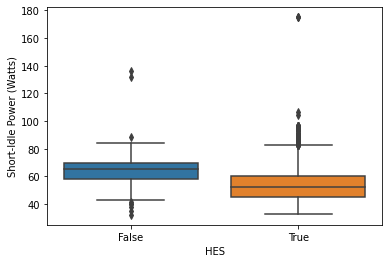

In [57]:
sns.boxplot(data = df, y = 'Short-Idle Power (Watts)', x = 'HES')

In [60]:
df.groupby('HES')['Short-Idle Power (Watts)'].describe()[['mean', 'std']]

,mean,std
HES,,
False,64.287917,14.781234
True,54.427978,13.394013


# Bronze Power Supplies vs Gold

In [88]:
print(f"Mean for Bronze PSU: {round(np.mean(df[(df['PSU'] == 'GP-P650B') & \
                            (df['CPU'] == (16.0, 3.4))]['Short-Idle Power (Watts)']), 2)}")
print(f"Mean for Gold PSU: {round(np.mean(df[~(df['PSU'] == 'GP-P650B') & \
                            (df['CPU'] == (16.0, 3.4)) & (df['PSU Size (Watts)'] == 650) & \
                            (df['GPU Bandwidth'] == 512.0)]['Short-Idle Power (Watts)']),2)}")

Mean for Bronze PSU: 49.57
Mean for Gold PSU: 50.86


In [85]:
print(f"P-Value comparing Bronze vs Gold 650 watt PSU : {stats.ttest_ind(df[(df['PSU'] == 'GP-P650B') & (df['CPU'] == (16.0, 3.4))]['Short-Idle Power (Watts)'], (df[~(df['PSU'] == 'GP-P650B') & (df['CPU'] == (16.0, 3.4)) & (df['PSU Size (Watts)'] == 650) & (df['GPU Bandwidth'] == 512.0)]['Short-Idle Power (Watts)'])).pvalue}")

P-Value comparing Bronze vs Gold 650 watt PSU : 0.4214969328487391


# Modeling Power Consumption for Skytech Gaming
## Import, cleaning

In [114]:
skytech = pd.read_csv('full_data.csv')
skytech = skytech[skytech['Brand'].str.contains('Skytech')]
skytech = skytech[skytech['Computer Type'] == 'High Expandability Computer']
skytech = skytech[[
    'Number of CPU Cores', 'Core Speed (gigahertz)', \
    'Expandability Score', \
    'Number of 3.5" hard-disk drives and Others (other than main storage)', \
    'Number of solid-state drives (other than main storage)', \
    'First Discrete GPU Frame Buffer Bandwidth (rounded to nearest gigabyte per second)', \
    'Total Number of System Memory Channels Used', \
    'First channel system memory (gigabytes)', \
    'First channel system memory bandwidth (gigabytes/second)', \
    'Motherboard model number', \
    'Power supply model number', \
    'Internal power supply size (watts)', \
    'Short-idle power (watts)']]
skytech['Motherboard model number'] = skytech['Motherboard model number'].str.upper()
skytech['Power supply model number'] = skytech['Power supply model number'].str.upper()
skytech.drop_duplicates(inplace = True)
skytech['RAM Size'] = skytech.apply(lambda x: x['Total Number of System Memory Channels Used'] * x['First channel system memory (gigabytes)'], axis = 1)
skytech['CPU'] = tuple(zip(skytech['Number of CPU Cores'], skytech['Core Speed (gigahertz)']))
skytech.drop(columns = ['Total Number of System Memory Channels Used', 'First channel system memory (gigabytes)'], inplace = True)
skytech.columns = ['CPU Cores', 'Core Speed (GHz)', 'Expandability Score', 'Number of hard disk drives', 'Number of extra solid-state drives', 'GPU Bandwidth', 'Ram Speed (GB/s)', 'Motherboard', 'PSU', 'PSU Size (Watts)', 'Short-Idle Power (Watts)', 'RAM Capacity (GB)', 'CPU']
skytech = skytech[['CPU Cores', 'Core Speed (GHz)', 'Expandability Score' , 'Number of hard disk drives', 'Number of extra solid-state drives', 'GPU Bandwidth', 'Ram Speed (GB/s)', 'RAM Capacity (GB)', 'Motherboard', 'PSU', 'PSU Size (Watts)', 'Short-Idle Power (Watts)']]
skytech.sample(5)

,CPU Cores,Core Speed (GHz),Expandability Score,Number of hard disk drives,Number of extra solid-state drives,GPU Bandwidth,Ram Speed (GB/s),RAM Capacity (GB),Motherboard,PSU,PSU Size (Watts),Short-Idle Power (Watts)
7691,8.0,3.6,725.0,0.0,0.0,912.0,25.6,16.0,B550 UD AC,THERMALTAKE PS-TTP-0600NNFAGU-1,600.0,51.7
7436,8.0,2.5,710.0,0.0,0.0,448.0,25.6,16.0,B560 AC-HES,GAMDIAS GD-KRATOS P1A-750G,750.0,44.9
7461,6.0,2.9,755.0,0.0,0.0,128.0,24.0,16.0,B560 DS3H,GAMDIAS HELIOS P1-600G,600.0,42.2
4661,8.0,3.8,810.0,0.0,0.0,512.0,25.6,16.0,X570 RIPTIDE,AG-750M,750.0,56.8
7699,8.0,3.6,725.0,0.0,0.0,912.0,25.6,16.0,B550 UD AC,GP-P750GM,750.0,73.0


## Converting MOBO Model to Chipset

In [3]:

def mobo_to_chipset(x):
    chipsets = ('B550', 'B560', 'X570', 'Z590')
    if 'B550' in x:
        return('B550')
    elif 'B560' in x:
        return('B560')
    elif 'X570' in x:
        return('X570')
    elif 'Z590' in x:
        return('Z590')
    else:
        return('Unknown')

In [4]:
skytech['Chipset'] = skytech.Motherboard.apply(lambda x: mobo_to_chipset(x))
skytech.drop(columns = ['PSU', 'Motherboard'], inplace = True)

In [5]:
skytech

,CPU Cores,Core Speed (GHz),Expandability Score,Number of hard disk drives,Number of extra solid-state drives,GPU Bandwidth,Ram Speed (GB/s),RAM Capacity (GB),PSU Size (Watts),Short-Idle Power (Watts),Chipset
1705,8.0,3.6,510.0,0.0,0.0,912.0,25.6,16.0,750.0,50.4,B550
2736,8.0,3.6,610.0,0.0,0.0,608.0,28.8,16.0,750.0,88.5,Z590
2737,8.0,3.8,730.0,0.0,0.0,608.0,25.6,32.0,750.0,56.8,X570
2739,8.0,3.8,730.0,0.0,0.0,608.0,25.6,16.0,750.0,59.4,X570
2740,12.0,3.7,730.0,0.0,0.0,608.0,28.8,32.0,850.0,73.0,X570
...,...,...,...,...,...,...,...,...,...,...,...
8164,16.0,3.4,730.0,0.0,0.0,936.0,28.8,32.0,1000.0,66.0,X570
8165,16.0,3.4,735.0,0.0,0.0,936.0,28.8,32.0,1000.0,67.3,X570
8166,8.0,3.8,730.0,0.0,0.0,912.0,25.6,16.0,850.0,60.4,X570
8168,8.0,2.5,710.0,0.0,0.0,448.0,25.6,16.0,650.0,54.4,B560


## Looking at consumption by PSU wattage

Pearson's Correlation Coeff: 0.5608739139384483


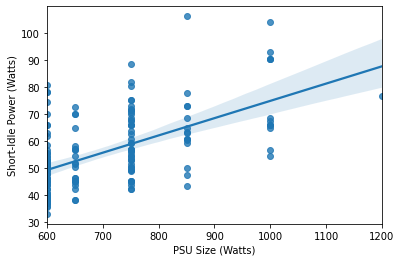

In [26]:
from scipy import stats
sns.regplot(data = skytech, x = 'PSU Size (Watts)', y = 'Short-Idle Power (Watts)')
print(f"Pearson's Correlation Coeff: {stats.pearsonr(skytech['PSU Size (Watts)'], skytech['Short-Idle Power (Watts)'])[0]}")


## Addressing chipset class imbalance

In [7]:
skytech.Chipset.value_counts()

B550    83
X570    35
B560    32
Z590     7
Name: Chipset, dtype: int64

In [6]:
from imblearn.over_sampling import RandomOverSampler 
ros = RandomOverSampler(random_state=42)
skytech_resampled, chipset_resampled = ros.fit_resample(skytech.drop(columns = ['Chipset']), skytech['Chipset'])

In [49]:
skytech_resampled['Chipset'] = chipset_resampled

In [50]:
skytech_resampled.sample(5)

,CPU Cores,Core Speed (GHz),Expandability Score,Number of hard disk drives,Number of extra solid-state drives,GPU Bandwidth,Ram Speed (GB/s),RAM Capacity (GB),PSU Size (Watts),Short-Idle Power (Watts),Chipset
275,8.0,3.6,700.0,0.0,0.0,936.0,28.8,32.0,850.0,47.5,Z590
298,8.0,3.6,610.0,0.0,0.0,608.0,28.8,16.0,750.0,88.5,Z590
183,6.0,2.9,710.0,0.0,0.0,448.0,25.6,16.0,600.0,46.4,B560
310,8.0,3.6,585.0,0.0,0.0,912.0,25.6,32.0,850.0,63.0,Z590
42,6.0,3.7,580.0,0.0,0.0,608.0,25.6,16.0,750.0,71.9,B550


In [277]:
skytech_resampled.Chipset.value_counts()

B550    83
X570    83
B560    83
Z590    83
Name: Chipset, dtype: int64

## Model Training

In [27]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

scaler = MinMaxScaler()
X = scaler.fit_transform(pd.get_dummies(skytech_resampled.drop(columns = ['Short-Idle Power (Watts)'])))
y = skytech_resampled['Short-Idle Power (Watts)']

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2)
from sklearn.ensemble import GradientBoostingRegressor
reg = GradientBoostingRegressor()
reg.fit(X_train, y_train)
reg.score(X_test, y_test)

0.7082298842888437

In [29]:
reg.score(X_train, y_train)

0.921893927390209

In [41]:
grid = {'learning_rate': [i / 100 for i in range(1,100, 5)] + [.5, 1],
               'n_estimators': [i for i in range(50, 200, 20)],
               'max_depth': [i for i in range (2, 7)]}
search = GridSearchCV(reg, param_grid = grid, cv = 3)
search.fit(X_train, y_train)
best = search.best_estimator_
best.fit(X_train, y_train)
best.score(X_test, y_test)

0.7112368589801347

In [31]:
best.score(X_train, y_train)

0.9796469789551963

In [32]:
from sklearn.ensemble import RandomForestRegressor
rfr = RandomForestRegressor()
rfr.fit(X_train, y_train)
print(f"Test score: {rfr.score(X_train, y_train)}")
print(f"Test score: {rfr.score(X_test, y_test)}")

Test score: 0.9660454457022274
Test score: 0.7261724017454386


In [33]:
rfr_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}
search_rfr = GridSearchCV(rfr, param_grid = rfr_grid, cv = 3)
search_rfr.fit(X_train, y_train)
best_rfr = search_rfr.best_estimator_
best_rfr.fit(X_train, y_train)
best_rfr.score(X_test, y_test)

0.6633570613633385

In [35]:
from sklearn.metrics import mean_squared_error
rfr_y_preds = best_rfr.predict(X_test)
print('Tuned Random Forest Results')
print('----------------------------')
print(f"Training R^2 Score: {round(best_rfr.score(X_train, y_train),2)}")
print(f"Testing R^2 Score: {round(best_rfr.score(X_test, y_test),2)}")
print(f"Training RMSE: {round(np.sqrt(mean_squared_error(y_train, best_rfr.predict(X_train))),2)}")
print(f"Training RMSE: {round(np.sqrt(mean_squared_error(y_test, rfr_y_preds)),2)}")

Tuned Random Forest Results
----------------------------
Training R^2 Score: 0.85
Testing R^2 Score: 0.66
Training RMSE: 5.77
Training RMSE: 8.81


In [39]:
search_rfr.best_estimator_

RandomForestRegressor(max_depth=90, max_features=3, min_samples_leaf=3,
                      min_samples_split=8, n_estimators=300)

In [42]:
from sklearn.metrics import mean_squared_error
y_preds = best.predict(X_test)
print('Tuned Gradient Boosting Results')
print('----------------------------')
print(f"Training R^2 Score: {round(best.score(X_train, y_train),2)}")
print(f"Testing R^2 Score: {round(best.score(X_test, y_test),2)}")
print(f"Training RMSE: {round(np.sqrt(mean_squared_error(y_train, best.predict(X_train))),2)}")
print(f"Training RMSE: {round(np.sqrt(mean_squared_error(y_test, y_preds)),2)}")

Tuned Gradient Boosting Results
----------------------------
Training R^2 Score: 0.98
Testing R^2 Score: 0.71
Training RMSE: 2.16
Training RMSE: 8.16


In [45]:
search.best_estimator_

GradientBoostingRegressor(learning_rate=0.31, max_depth=4, n_estimators=90)

/usr/local/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:ylabel='Short-Idle Power (Watts)'>

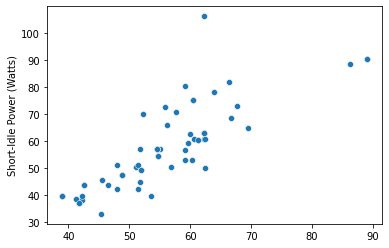

In [43]:
sns.scatterplot(rfr_y_preds, y_test)

/usr/local/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:ylabel='Short-Idle Power (Watts)'>

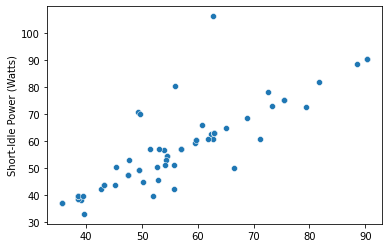

In [44]:
sns.scatterplot(y_preds, y_test)

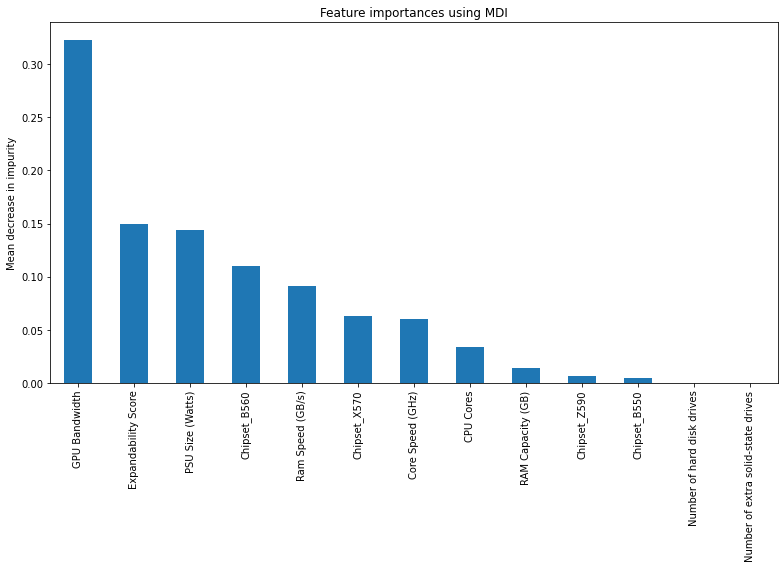

In [329]:
importances = best.feature_importances_
cols = pd.get_dummies(skytech_resampled.drop(columns = ['Short-Idle Power (Watts)'])).columns
feature_importances = pd.Series(importances, index=cols).sort_values(ascending = False)

fig, ax = plt.subplots()
fig.set_figheight(8)
fig.set_figwidth(11)
feature_importances.plot.bar(ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

## Simplified model

In [102]:
scaler = MinMaxScaler()
X = scaler.fit_transform(pd.get_dummies(
    skytech_resampled[
        ['Expandability Score', 'GPU Bandwidth', 'PSU Size (Watts)', 'Chipset']
    ]))
y = skytech_resampled['Short-Idle Power (Watts)']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .3)
grad = GradientBoostingRegressor().fit(X_train, y_train)
print(f"Simple model's training R^2: {round(grad.score(X_train, y_train), 2)}")
print(f"Simple model's test R^2: {round(grad.score(X_test, y_test), 2)}")

Simple model's training R^2: 0.86
Simple model's test R^2: 0.81
